## Safety Helmet Detection

Датасет состоит из 5000 изображений, которые содеражат разметку трех классов объектов: Каска, Человек, Голова.

Аннотации в формате PASCAL VOC

In [ ]:
from PIL import Image
import random
import yaml
import json
import os
from bs4 import BeautifulSoup
import shutil
from sklearn.model_selection import train_test_split

### Загрузка данных

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"petrovpav","key":"___"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

 99% 1.21G/1.22G [00:26<00:00, 43.5MB/s]
100% 1.22G/1.22G [00:26<00:00, 49.9MB/s]


In [ ]:
!unzip -q '/content/hard-hat-detection.zip'

### Обработка аннотаций

In [ ]:
!mkdir '/content/labels'

In [ ]:
classes = {'helmet':0,'head':1,'person':2}

In [ ]:
#Проходим по всем файлам аннотаций, меняем формат боксов и записываем в файл
for name in os.listdir('/content/annotations'):
  with open('/content/annotations/'+name, 'r') as file:
    xml_file = file.read() 
    soup = BeautifulSoup(xml_file, 'lxml') 
    size = soup.find("size")
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for tag in soup.findAll("object"): 
      cls = tag.find("name").text
      xmin = int(tag.find("xmin").text)
      ymin = int(tag.find("ymin").text)
      xmax = int(tag.find("xmax").text)
      ymax = int(tag.find("ymax").text) 

      w = xmax - xmin #вычисляем ширину бокса
      h = ymax - ymin #вычисляем высоту бокса
      x = xmin + (w / 2) #находим центр бокса по ширине
      y = ymin + (h / 2) #находим центр бокса по высоте

      #нормируем значения
      x = x / width
      w = w / width
      y = y / height
      h = h / height
      
      #записываем в файл
      with open('/content/labels/'+name[:-3]+'txt', 'a') as f:
        f.write('{} {} {} {} {}\n'.format(classes[cls], x, y, w, h))   



### Разбивка на выборки

In [ ]:
image_list = os.listdir('/content/images')
train_list, test_list = train_test_split(image_list, test_size=0.2)
val_list, test_list = train_test_split(test_list, test_size=0.5)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  4000
Проверочная выборка:  500
Тестовая выборка: 500


In [ ]:
!mkdir '/content/images/train/'
!mkdir '/content/images/valid/'
!mkdir '/content/labels/train/'
!mkdir '/content/labels/valid/'

In [ ]:
def move_data(name_list, folder, mode, img=True):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем 
  """
  format = 'png' if img==True else 'txt'
  for name in name_list:
    name = name[:-3]+format
    shutil.move(folder + name, folder + '{}/'.format(mode) + name)

In [ ]:
move_data(train_list, '/content/images/', 'train', img=True)
move_data(val_list, '/content/images/', 'valid', img=True)
move_data(train_list, '/content/labels/', 'train', img=False)
move_data(val_list, '/content/labels/', 'valid', img=False)

### Загрузка и обучение модели Yolo_v5

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10150, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10150 (delta 3), reused 8 (delta 3), pack-reused 10142
Receiving objects: 100% (10150/10150), 10.44 MiB | 21.60 MiB/s, done.
Resolving deltas: 100% (7033/7033), done.
/content/yolov5


In [ ]:
# создаем yaml файл

yaml_file = {'train':'/content/images/train' ,
            'val': '/content/images/valid',
            'nc' : '3',
            'names' : ['helmet','head','person']}

with open('helmet.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

In [ ]:
!python train.py --img 416 --batch 32 --epochs 25 --data helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt


train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=helmet.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=25, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-124-g1075488 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, 

<function matplotlib.pyplot.show>

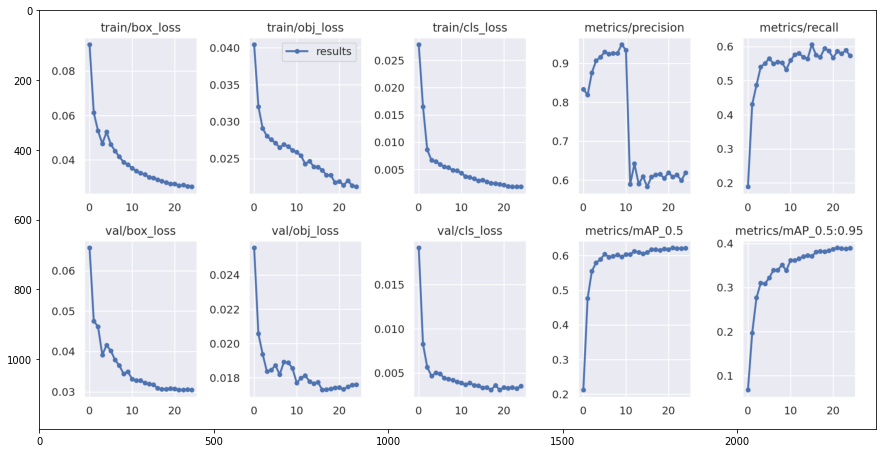

In [ ]:
img = Image.open('/content/yolov5/runs/train/exp2/results.png')
plt.figure(figsize=(15,15))
plt.imshow(img)    
plt.show

### Проверка на тестовой выборке

In [ ]:
!mkdir '/content/images/test/'
move_data(test_list, '/content/images/', 'test', img=True)

In [ ]:
!python detect.py --img 416 --source /content/images/test/  --weights runs/train/exp2/weights/best.pt --conf 0.25

detect: weights=['runs/train/exp2/weights/best.pt'], source=/content/images/test/, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-124-g1075488 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 290 layers, 20861016 parameters, 0 gradients
image 1/500 /content/images/test/hard_hat_workers100.png: 416x416 7 helmets, Done. (0.010s)
image 2/500 /content/images/test/hard_hat_workers1001.png: 416x416 4 helmets, Done. (0.010s)
image 3/500 /content/images/test/hard_hat_workers1004.png: 416x416 7 helmets, 2 persons, Done. (0.010s)
image 4/500 /content/images/test/hard_hat_workers1011.png: 416x416 2 helmets, Done. (0.010s)
image 5/500 /

<function matplotlib.pyplot.show>

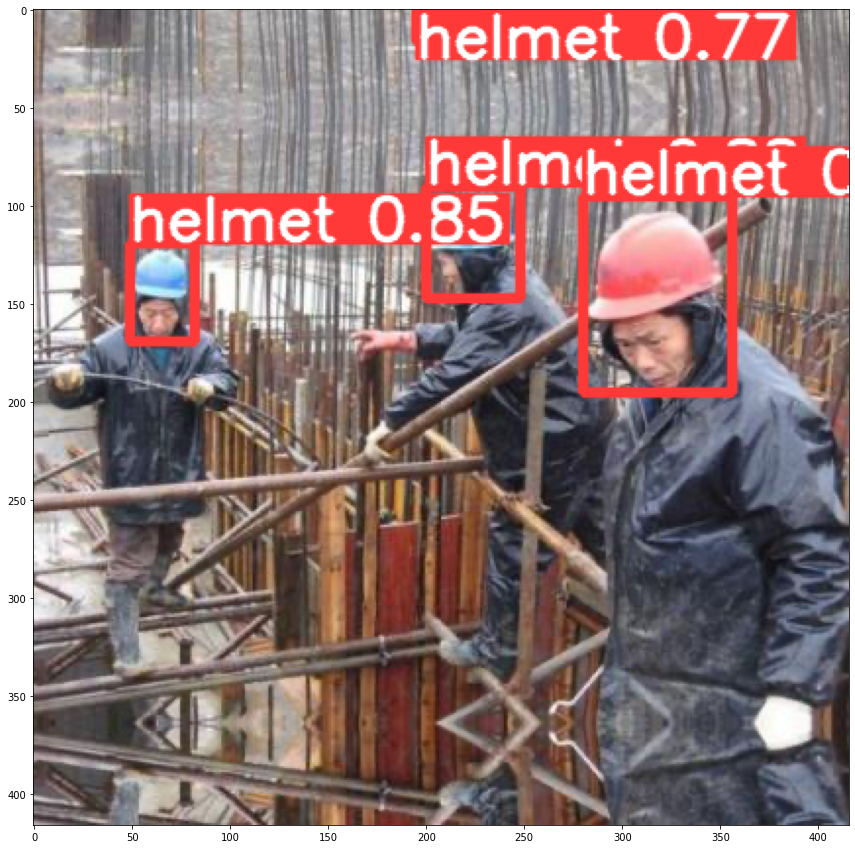

In [ ]:
n = random.randint(0,500)
img = Image.open('/content/yolov5/runs/detect/exp3/'+os.listdir('/content/yolov5/runs/detect/exp3/')[n])
plt.figure(figsize=(15,15))
plt.imshow(img)    
plt.show

<function matplotlib.pyplot.show>

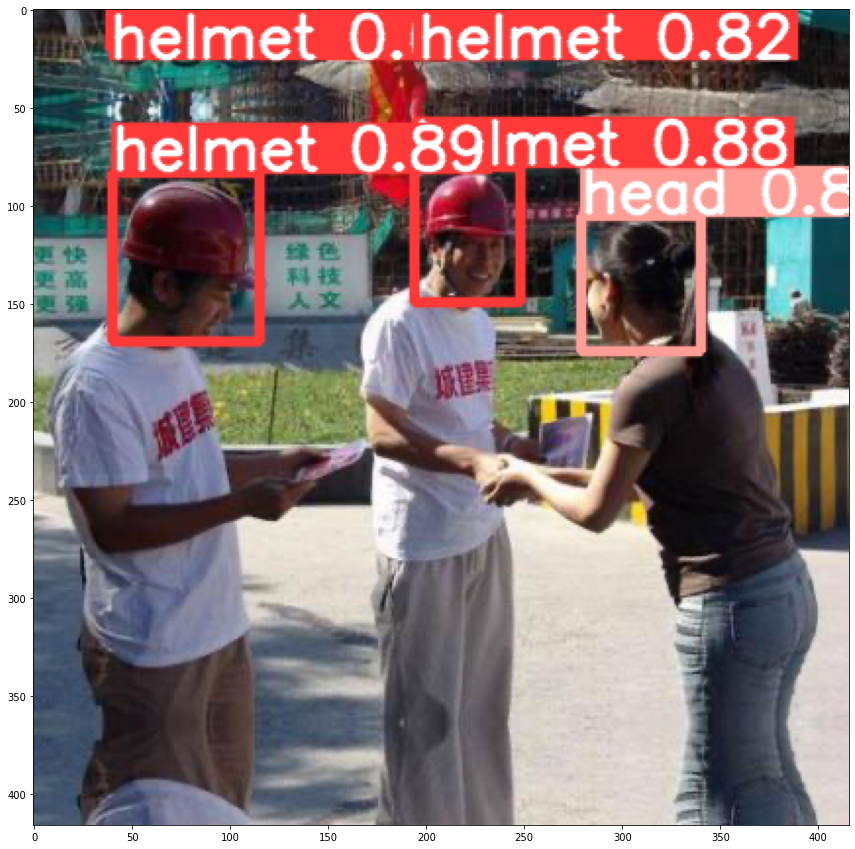

In [ ]:
img = Image.open('/content/yolov5/runs/detect/exp3/'+ 'hard_hat_workers4409.png')
plt.figure(figsize=(15,15))
plt.imshow(img)    
plt.show

**BibTeX**

@misc{make ml,

title={Hard Hat Dataset},

url={https://makeml.app/datasets/hard-hat-workers},

journal={Make ML}}

**License**

Public Domain

**Splash banner**

Photo by Ahsanization ッ on Unsplash

**Splash icon**

Icon by Skyclick available on Flaticon.